In [46]:
# Recommendation: `conda install --channel conda-forge geopandas`
import numpy as np
import math
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import entropy 
import shapely
import json
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from tqdm import tqdm
import os

import scorers
import redistricting
import matplotlib.ticker as ticker

In [47]:
def splits_to_regions_binary(row, splits):
    if splits is None:
        return 0
    if len(splits) == 0:
        return 0

    num = 0
    for v in splits:
        num = 2 * num + row[v]
    return num

def count_disjoints(geometry):
    if type(geometry) == Polygon:
        return 1 
    else:
        return len(geometry.geoms)

In [48]:
data_path = "../data/mggg-states/"
output_dir = "../output/"
run_name = "2018_abs_both_comp"

state = "NH"
DEGREE_LIMIT = 0
# scorers 
# crs = "EPSG:6505"

states = pd.read_csv("../states_2010.csv")
row = states.loc[states['abbrev'] == state]
row = [r for i,r in row.iterrows()][0]

voting_precincts = gpd.read_file(os.path.join(data_path,row["abbrev"]))
# voting_precincts = voting_precincts.to_crs(crs)
n_districts = row["districts"]
pop = row["population"]
d_votes = "USH16D" #row["dem_votes"]
r_votes = "USH16R" #row["rep_votes"]
voting_precincts.sample(n=1)

,PRES12R,PRES12D,GOV12R,GOV12D,USH12R,USH12D,GOV14R,GOV14D,PRES16R,PRES16D,...,GOV20R,PRES20D,PRES20R,SSEN20D,SSEN20R,USH20D,USH20R,SEN20D,SEN20R,geometry
140,353.0,343.0,405.0,349.0,350.0,296.0,287.0,239.0,423.0,267.0,...,607,364,472,304,513,263,456,399,450,"POLYGON ((966516.812 432057.313, 966876.125 43..."


In [49]:
voting_precincts.columns

Index(['PRES12R', 'PRES12D', 'GOV12R', 'GOV12D', 'USH12R', 'USH12D', 'GOV14R',
       'GOV14D', 'PRES16R', 'PRES16D', 'GOV16R', 'GOV16D', 'SEN16R', 'SEN16D',
       'USH16R', 'USH16D', 'GOV18R', 'GOV18D', 'COUNTY', 'STATE', 'STATEFP',
       'COUNTYFP', 'Precinct', 'TOTPOP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN',
       'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'HISP', 'H_WHITE',
       'H_BLACK', 'H_AMIN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP',
       'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP',
       '2MOREVAP', 'HDIST', 'SEND', 'CD', 'SSEN14R', 'SSEN14D', 'SSEN16R',
       'SSEN16D', 'EC12R', 'EC12D', 'EC14R', 'EC14D', 'EC20D', 'EC20R',
       'GOV20D', 'GOV20R', 'PRES20D', 'PRES20R', 'SSEN20D', 'SSEN20R',
       'USH20D', 'USH20R', 'SEN20D', 'SEN20R', 'geometry'],
      dtype='object')

In [50]:
voting_precincts['REPRESENTATIVE_POINT'] =  voting_precincts.centroid # voting_precincts.representative_point() https://gis.stackexchange.com/a/414263
voting_precincts['RP_LON'] = voting_precincts['REPRESENTATIVE_POINT'].apply(lambda p: p.x)
voting_precincts['RP_LAT'] = voting_precincts['REPRESENTATIVE_POINT'].apply(lambda p: p.y)

In [51]:
orig_voting = voting_precincts[[d_votes, r_votes]].sum()/(voting_precincts[[d_votes, r_votes]].sum().sum())
orig_voting

USH16D    0.515475
USH16R    0.484525
dtype: float64

In [52]:
holder = []   
redistricting.split_this(df=voting_precincts, n_districts=n_districts, pop_col=pop, dem_col=d_votes, rep_col=r_votes, orig_dem=orig_voting[d_votes], orig_rep=orig_voting[r_votes], degree_limit=DEGREE_LIMIT, score_fn=scorers.abs_diff_mean_fn, holder=holder)

100%|██████████| 360/360 [00:02<00:00, 131.66it/s]


In [53]:
all_districts = pd.concat(holder).reset_index(drop=True)
split_columns = [c for c in all_districts.columns if c.startswith("SPLIT_")]

for c in split_columns:
    all_districts[c] = all_districts[c].fillna(0)

all_districts['DISTRICT'] = all_districts.apply(splits_to_regions_binary, splits=split_columns, axis=1)
all_districts['DISTRICT'].nunique()

2

In [54]:
# Shuffle for coloring
n_districts = all_districts['DISTRICT'].nunique()
random_districts = np.random.choice(np.linspace(0,n_districts-1,n_districts), size=n_districts, replace=False, p=None)
shuffle_dict = dict(zip(all_districts["DISTRICT"].unique(), random_districts))
all_districts["SHUFFLED"] = all_districts["DISTRICT"].apply(lambda x: shuffle_dict[x])

In [55]:
print(all_districts.groupby("SHUFFLED").sum()[pop].sum())
pop_summary = all_districts.groupby("SHUFFLED").sum()[pop].reset_index()
pop_summary['pct_deviation'] = (pop_summary[pop] - (pop_summary[pop].sum()/n_districts))/(pop_summary[pop].sum()/n_districts)
pop_summary

1316470


,SHUFFLED,TOTPOP,pct_deviation
0,0.0,653674,-0.006929
1,1.0,662796,0.006929


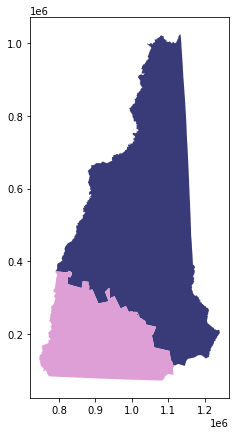

In [56]:
districts_df = all_districts.dissolve(by="SHUFFLED")
fig, ax = plt.subplots(1,1, figsize=(7,7))
districts_df.plot(ax=ax,cmap="tab20b")

# scale_x = 1e6
# scale_y = 1e6
# ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_x))
# ax.xaxis.set_major_formatter(ticks_x)

# ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
# ax.yaxis.set_major_formatter(ticks_y)

fig.savefig(os.path.join(output_dir, row["abbrev"],f"{row['abbrev']}_{run_name}_base.png"))

In [57]:
all_districts[['geometry', pop, r_votes, d_votes, 'DISTRICT', 'SHUFFLED'] + split_columns].to_file(os.path.join(output_dir, row["abbrev"],f"{row['abbrev']}_{run_name}.shp"))

c:\Users\yagne\anaconda3\envs\common\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


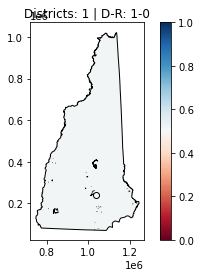

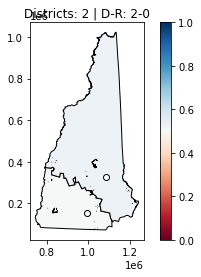

In [58]:
for i in range(len(split_columns)+1):
    redistricting.split_review(input_df=all_districts, split=i, split_cols=split_columns, d_votes=d_votes, r_votes=r_votes, pop=pop, plot_party=True, figsize=(6,4), save=os.path.join(output_dir, row["abbrev"],f"{row['abbrev']}_{run_name}_{i+1}.png"))


In [59]:
all_districts.groupby('DISTRICT')['USH20D'].sum()

DISTRICT
0    214698
1    199197
Name: USH20D, dtype: int64

In [60]:
all_districts.groupby('DISTRICT')['USH20R'].sum()

DISTRICT
0    182099
1    171946
Name: USH20R, dtype: int64